In [1]:
import os
import librosa 
import torch
import matplotlib
import matplotlib.pyplot as plt
import random

matplotlib.use('Agg')

%matplotlib inline

from matplotlib.colors import Normalize
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import ArgumentParser
from omegaconf import OmegaConf
from unicodedata import normalize

#from utils.utils import get_commit_hash
from tacotron import Tacotron
from datasets import TextMelDataset
from datasets.text import Language
from datasets.text.symbols import eng_symbols
#from utils.plots import plot_spectrogram

def get_text(text):
    stoi = { s : i for i,s in enumerate(eng_symbols)}
    text_norm = [80]
    for t in text:
        # print(t)
        chk = 0

        if t > 5000:
            t = t - 1000

            text_norm.append(stoi[chr(t)])
        else:
            text_norm.append(stoi[chr(t)])
    #text_norm.append(0)
    text_norm = torch.LongTensor(text_norm)
    
    return text_norm

if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('-c', '--config', type=str, required=True,
                        help="path of configuration yaml file")
    parser.add_argument('-g', '--gpus', type=str, default=None,
        help="Number of gpus to use (e.g. '0,1,2,3'). Will use all if not given.")
    parser.add_argument('-n', '--name', type=str, required=True,
                        help="Name of the run.")
    parser.add_argument('-p', '--checkpoint_path', type=str, default=None,
                        help="path of checkpoint for resuming")
    parser.add_argument('-s', '--save_top_k', type=int, default=-1,
                        help="save top k checkpoints, default(-1): save all")
    parser.add_argument('-f', '--fast_dev_run', type=bool, default=False,
                        help="fast run for debugging purpose")
    parser.add_argument('--val_epoch', type=int, default=1,
                        help="run val loop every * training epochs")
    lu=['-c','config/inference.yaml','-n','trash','-p']
    
    #lu.append('/raid/audio/kwkim/multi_tts/chkpt/trial_with_vae/8b67a6f-epoch=79.ckpt')
    #lu.append('/raid/audio/kwkim/multi_tts/chkpt/trash2/4d7452f-epoch=7.ckpt')
    #lu.append('/raid/kwkim/multi_tts/chkpt/mktv_norm/4d7452f-epoch=36.ckpt')
    lu.append('/raid/kwkim/multi_tts/chkpt/moing/4d7452f-epoch=37.ckpt')
    
    args = parser.parse_args(lu)
    
    #hp = OmegaConf.load(args.config)

    
    net=Tacotron.load_from_checkpoint(args.checkpoint_path).cuda().eval()
    hp = net.hp
    net.freeze()

    
    language_list = [hp.kor, hp.eng, hp.jap]
    x_list = []
    train_dir_list = []
    train_meta_list = []
    speaker_list = []
    for x in language_list:
        x_list.append(x)
        train_dir_list.append(x.train_dir)
        train_meta_list.append(x.train_meta)
        speaker_list += x.speakers
    trainset = TextMelDataset(hp, x_list, train_dir_list, train_meta_list, True)


In [17]:

    #text=input('문자열을 입력하세요: ')

    #text="{L EH T S} {S T AH D IY} {AH D V AE N S T} {F AO R} {N EH K S T} {T AY M}!"
    #text="{W EH L}, {IH T} {D AH Z AH N T} {R IH L IY} {M AE T ER}."
    #text="{AY} {G AA T} {K AA T} {AH P} {R IY D IH NG} {DH AH} {D R AE F T} {AH V} {Y AO R} {L EY T AH S T} {P EY P ER}."
    #text="{W AH T} {L AE NG G W AH JH AH Z} {AA R} {AH V EY L AH B AH L} {F AO R} {DH AH} {AA D IY OW} {G AY D}?"
    text="{K AE N} {AY}{AY}{M EY K} {AH} {R EH Z ER V EY SH AH N} {F AO R} {T AH N AY T}?"
    #text="{DH EH L} {B IY} {S T EY IH NG} {DH EH R} {F AO R} {AH} {W IY K}."
    #text="{AO L} {IH N F AO R M EY SH AH N} {P R IY Z EH N T AH D} {IH N} {DH IH S} {D AA K Y AH M EH N T} {IH Z} {B EY S T} {AA N} {IH NG G L IH SH} {JH IY} {T UW} {P IY}."
    #text="{HH EH L OW} {EH V R IY B AA D IY}, {DH IH S} {IH Z} {M IH K Y AH NG} {T IY V IY}."
    #text="{AY}{AY}{AE M} {G L AE D} {DH AE T} {AY} {K AE N} {F AY N AH L IY} {G R IY T} {Y UW} {IH N} {IH NG G L IH SH}."
    #text="{DH IH S} {IH Z} {R IY S ER CH ER} {K AH NG} {W UH K} {K IH M} {AH V} {DH AH} {B R EY N} {T IY M}."
    #text="{AY} {JH OY N D} {L AE S T} {Y IH R} {AE N D} {HH AE V} {B IH N} {K AH N D AH K T IH NG} {R IY S ER CH} {AA N} {S P IY CH} {S IH N TH AH S AH S}."
    #text="'{M AY N D S L AE B Z} {T EH K S T} {T UW} {S P IY CH} {T EH K N AA L AH JH IY} {IH Z} {R IH L IY} {AH M EY Z IH NG}, {AY} {W AA N T} {EH V R IY W AH N} {T UW} {T R AY} {DH IH S} {T EH K N IY K}.'"
    #text="최근 테슬라의 비트코인 결제 지원 중단과 중국 정부의 가상자산 채굴 단속 강화 조치 등 다양한 악재가 터지며 폭락한 비트코인은 최근 십 여일 동안 삼만 사만 달러 부근에서 박스권을 형성해 횡보하는 모습을 보이고 있다"
    #text="교도통신은 중국-싱가포르간 외교 소식통을 인용해 시 주석이 북미정상회담의 합의 내용 중 한반도 평화협정 체결 내용이 있을 경우 싱가포르를 방문할 계획이었지만, 평화협정 관련 내용이 빠질 것으로 예상되자 싱가포르에 가지 않았다고 설명했습니다."
    #text="맥북, 달러, 게임,  주스, 돈가스, 버스, 사인펜, 서비스, 사이판"
    #text="나는 누구보다 민주주의의 의의에 대해 잘 설명할 수 있는 사람이다."
    #text = "나는,, 읽기 쉬운 마음이야. 당신도, 쓰윽 훑고 가셔요. 달랠 길 없는, 외로운 마음 있지. 머물다 가셔요."
    #text = "내게, 긴 여운을 남겨 줘요. 사랑을, 사랑을, 해줘요. 미련 남길 바엔, 그리워 아픈 게 나아. 서둘러 안겨본 그 품은 따스할테니."
    #text = "그러다, 밤이 찾아오면, 우리 둘만의, 비밀을 새겨요. 추억할 그 밤 위에 갈피를 꽂고 선 남몰래 펼쳐보아요."
    #text = "언젠가, 또 그 날이 온대도, 우린 서둘러 뒤 돌지 말아요. 마주보던 그대로 뒷걸음치면서, 서로의 안녕을 보아요."
    #text = "헌데, 관상가 양반! 생각해보니 영 이상하구만. 나는 이미 왕이 되었는데 나보고 왕이 될 상이라니..."
    #text = "t-a-d-a-sh-i-pau-k-o-o-k-a-N-g-a-e-t-e-m-o-pau-y-a-h-a-r-i-t-a-N-n-i-j-i-j-i-ts-u-o-k-a-i-t-a-d-a-k-e-t-o-i-u-t-e-e-d-o-d-e-a-r-u-t-a-m-e-pau"
    #text = "sh-i-k-a-sh-i-pau-n-o-o-gy-o-o-n-o-j-o-o-sh-i-k-i-o-m-u-sh-i-sh-i-t-a-sh-u-t-a-i-n-o-o-h-o-o-y-a-s-e-N-r-i-m-a-u-N-d-o-o-pau-d-a-N-d-a-N-b-a-t-a-k-e-s-e-e-s-a-k-u-pau"
    #text = "k-e-i-my-o-o-sh-a-d-a-ts-u-n-a-n-a-r-e-e-sh-o-N-k-a-r-a-j-o-o-ch-o-k-a-N-a-f-u-r-e-r-u-k-a-t-a-r-i-m-a-d-e-h-a-b-a-h-i-r-o-i-hy-o-o-g-e-N-ry-o-k-u-o-m-o-ts-u"
    #text = "i-cl-p-o-o-d-e-gy-o-gy-o-o-t-o-sh-o-o-gy-o-o-d-e-ry-a-n-e-s-u-k-o-o-w-a-h-a-N-e-i-sh-i-t-e-i-t-a"
    
    speaker= 'moing'
    lang = [1]
    
    text = trainset.get_text(text, lang[0]).long()
    
    lang = torch.LongTensor(lang)
    text=text.unsqueeze(0)
    
    
    speaker_dict = {spk:idx for idx, spk in enumerate(speaker_list)}
    #speaker_dict = {spk: idx for idx, spk in enumerate(hp.kor.speakers+hp.eng.speakers+hp.esp.speakers+hp.fra.speakers+hp.jap.speakers+hp.rus.speakers)}
    spk_id=[speaker_dict[speaker]]
    print(spk_id)
    spk_id = torch.LongTensor(spk_id)    
    
    text=text.cuda()
    spk_id=spk_id.cuda()
    lang = lang.cuda()
    
    with torch.no_grad():
        mel, _, align = net.inference(text,spk_id,lang)

    savepath="output/g2p_testmodel.mel"
    
    torch.save(mel, savepath)

[26]
tensor([[ 13, 193, 175, 196,  12, 179, 179, 195, 186, 193,  12, 176,  12, 201,
         184, 211, 185, 208, 186, 203, 176, 196,  12, 187, 177, 201,  12, 204,
         176, 196, 179, 204,  11,   1]], device='cuda:0')


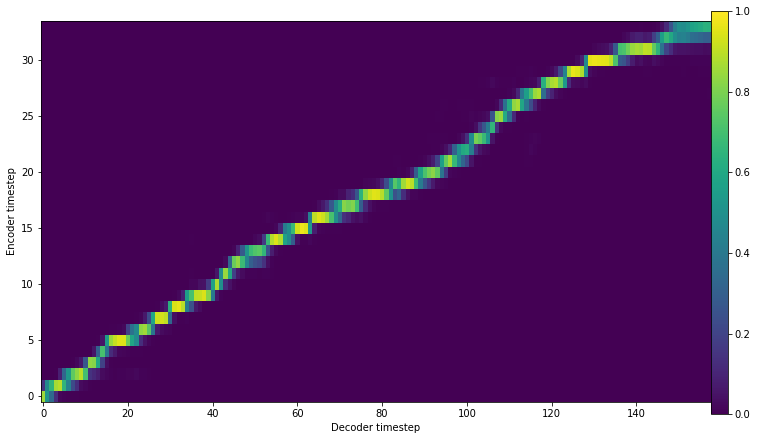

In [18]:
    align = align.cpu()
    align = align.squeeze(0)
    align = align.T
    fig = plt.figure(figsize=(12, 7))
    plt.imshow(align, aspect='auto', origin='lower', interpolation='none',
        norm=Normalize(vmin=0.0, vmax=1.0))
   
    plt.xlabel('Decoder timestep')
    plt.ylabel('Encoder timestep')
    
    cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    plt.colorbar(cax=cax)

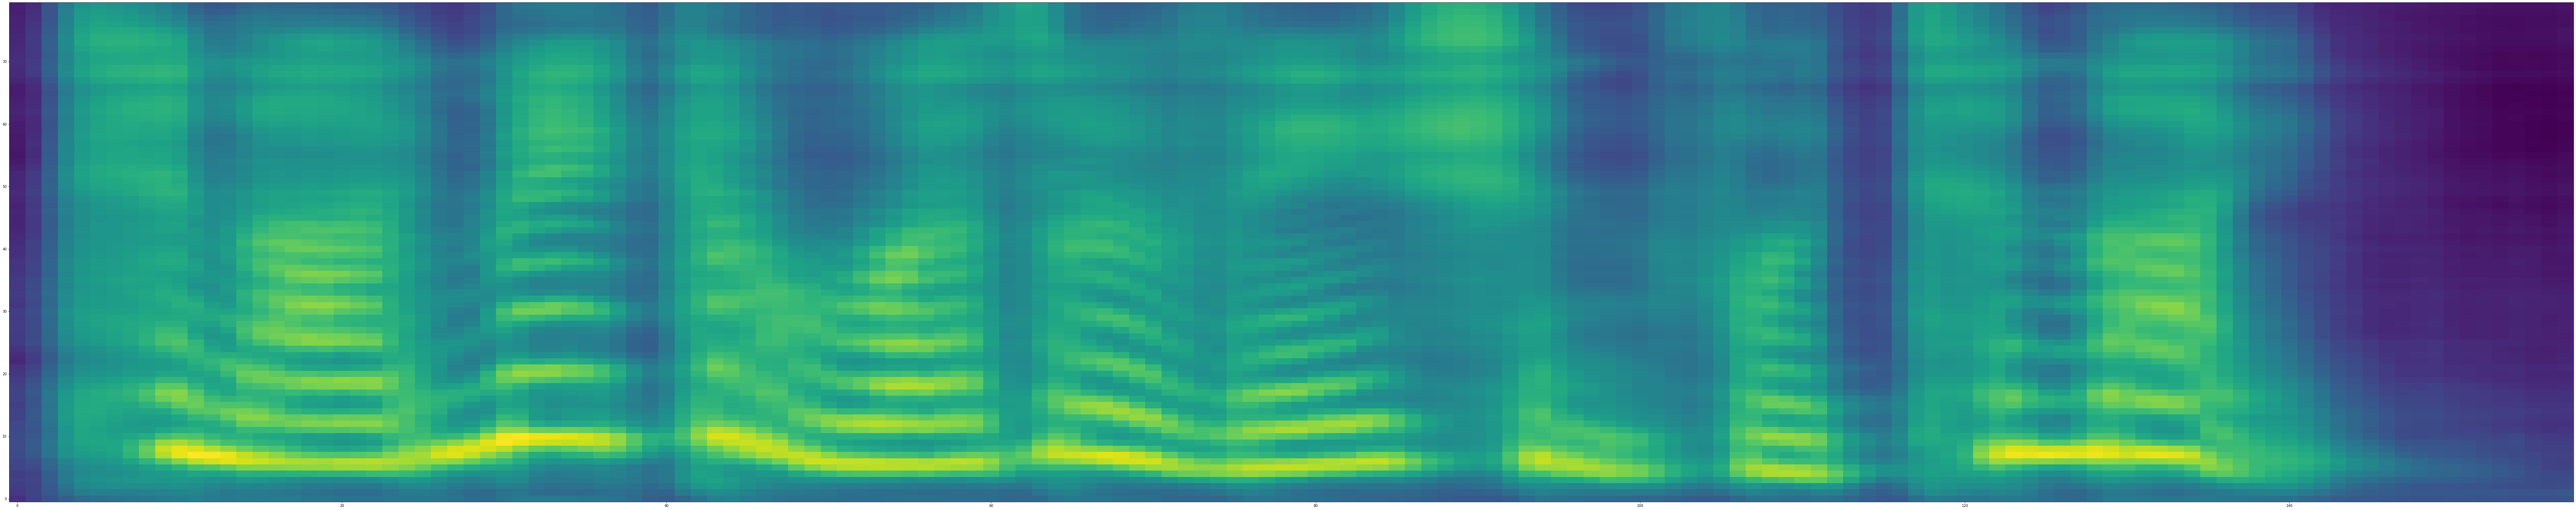

In [19]:
    mel_img=mel.squeeze(0)
    mel_img=mel_img.cpu().detach().numpy()
    
    
    fig = plt.figure(figsize=(135,27))
    #cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    #plt.colorbar(format='%+2.0f dB')
    plt.savefig('mel.png')
    plt.imshow(mel_img, aspect = 'auto', origin='lower', interpolation='none')